In [15]:
!pip install pyscf qiskit qiskit_ibm_runtime qiskit-addon-sqd ffsim -q


Molecules: ['H2', 'H2O', 'LiOH', 'CO', 'N2']
Profiling H2 ...
Profiling H2O ...
Profiling CO ...
Profiling N2 ...
Wrote per-molecule CSVs and combined_flat.csv to: /content/profiles


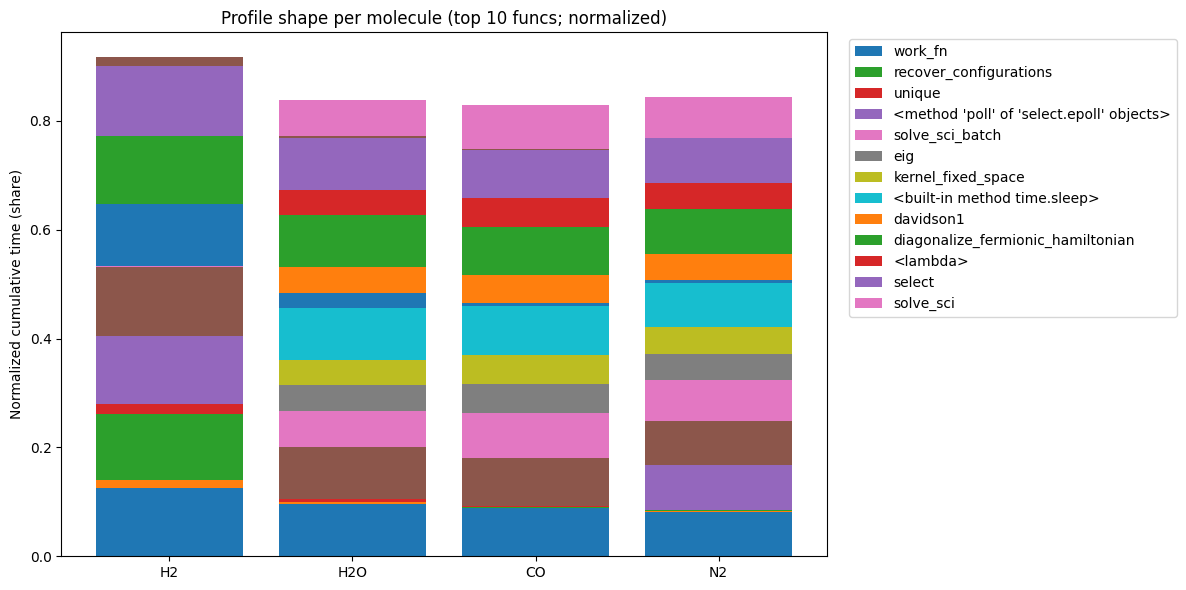

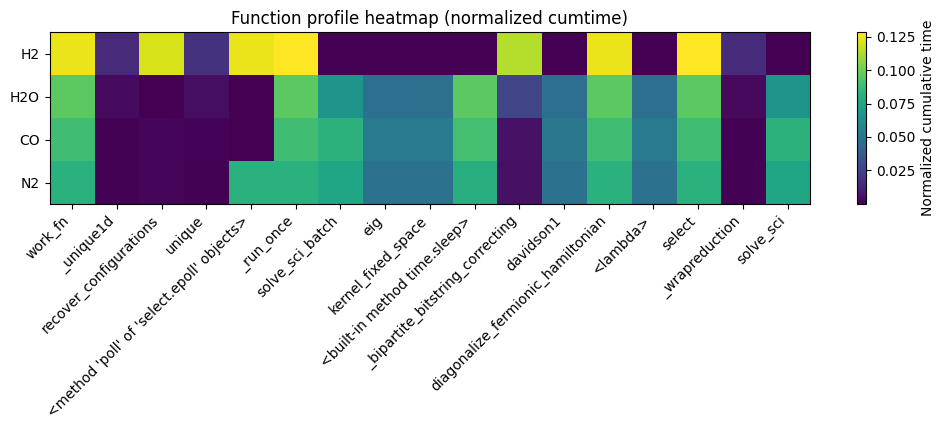

In [22]:
# ---- Setup & loads ----------------------------------------------------------
import os, io, csv, pickle, cProfile, pstats
from pathlib import Path
from typing import Callable, Dict, Any, Tuple
import pandas as pd
import matplotlib.pyplot as plt
import pyscf
import pyscf.cc
import pyscf.mcscf
import ffsim
import numpy as np
import matplotlib.pyplot as plt
import pickle
from typing import Sequence

import rustworkx
from qiskit.providers import BackendV2
from rustworkx import NoEdgeBetweenNodes, PyGraph

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
import pickle
from functools import partial

from qiskit_addon_sqd.fermion import (
    SCIResult,
    diagonalize_fermionic_hamiltonian,
    solve_sci_batch,
)

# Where to read/write
PICKLE_PATH = "/content/all_mols.pkl"    # <-- set this to your pickle path
OUTDIR = Path("profiles"); OUTDIR.mkdir(exist_ok=True, parents=True)

with open(PICKLE_PATH, "rb") as f:
    all_mols: Dict[str, Dict[str, Any]] = pickle.load(f)

print("Molecules:", list(all_mols.keys()))

# ---- What to profile (FIXED) -----------------------------------------------
def _extract_meas(case: dict):
    # Try to pull the bit-array the function expects
    pr = case.get("pub_result")
    if pr is not None:
        try:
            return pr.data.meas
        except Exception:
            pass
    # If absent, fall back to an all-zero placeholder with the right width
    # (keeps the profiler running CPU-only). Adjust if your function requires real data.
    import numpy as np
    norb = int(case["norb"])
    # measurement array shape guess: (shots, 2*norb)
    return np.zeros((1, 2 * norb), dtype=np.uint8)

# def work_fn(case: dict):
#     meas = _extract_meas(case)
#     bitstrings = case['bitstrings_block_ab']
#     init_occ   = case['initial_occupancies']  # may be None

#     diagonalize_fermionic_hamiltonian(
#         case["h1"], case["eri"], bitstrings,
#         norb=case["norb"], nelec=case["nelec"],
#         # ...
#         initial_occupancies=init_occ,
# )

#     return diagonalize_fermionic_hamiltonian(
#         case["h1"],
#         case["eri"],
#         bitstrings,                          # <-- actual bit-array
#         norb=case["norb"],
#         nelec=case["nelec"],           # <-- tuple (n_alpha, n_beta), NOT sum(...)
#         samples_per_batch=256,
#         num_batches=3,
#         energy_tol=1e-3,
#         occupancies_tol=1e-3,
#         max_iterations=5,
#         sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=200),
#         symmetrize_spin=True,
#         carryover_threshold=1e-4,
#         callback=callback,
#         seed=12345,
#         initial_occupancies=init_occ,
#     )
from qiskit.primitives import BitArray
import numpy as np

def work_fn(case: dict):
    norb = int(case["norb"])
    na, nb = case["nelec"]

    # canonical logical [alpha-block | beta-block] from your prep notebook
    bitstrings = np.asarray(case["bitstrings_block_ab"], dtype=np.uint8)
    if bitstrings.ndim == 1:
        bitstrings = bitstrings[None, :]
    if bitstrings.shape[1] != 2 * norb:
        raise ValueError(f"Expected {2*norb} bits, got {bitstrings.shape[1]}")

    init_occ = case.get("initial_occupancies", None)
    if bitstrings.size == 0:
        # optional HF seed if a run had zero valid shots
        alpha = np.r_[np.ones(na, dtype=np.uint8), np.zeros(norb - na, dtype=np.uint8)]
        beta  = np.r_[np.ones(nb, dtype=np.uint8), np.zeros(norb - nb, dtype=np.uint8)]
        init_occ = np.concatenate([alpha, beta])
        bitstrings = init_occ[None, :]

    # >>> MINIMAL FIX: pack to bytes and wrap as BitArray <<<
    # SQD will call np.unpackbits(bit_array.array)[..., -bit_array.num_bits:], so give it packed bytes.
    packed = np.packbits(bitstrings, axis=-1, bitorder="big")   # match NumPy's default unpack ("big")
    ba = BitArray(packed, num_bits=bitstrings.shape[1])         # Qiskit 2.0 BitArray API

    return diagonalize_fermionic_hamiltonian(
        case["h1"],
        case["eri"],
        ba,                              # <-- pass BitArray, not ndarray
        norb=norb,
        nelec=(na, nb),
        samples_per_batch=256,
        num_batches=3,
        energy_tol=1e-3,
        occupancies_tol=1e-3,
        max_iterations=5,
        symmetrize_spin=True,
        carryover_threshold=1e-4,
        callback=None,
        seed=12345,
        initial_occupancies=init_occ,
    )


# ---- Profiling helpers ------------------------------------------------------
def _stats_to_df(ps: pstats.Stats) -> pd.DataFrame:
    rows = []
    for (fn, line, name), (cc, nc, tt, ct, callers) in ps.stats.items():
        rows.append({
            "filename": fn, "lineno": line, "func": name,
            "prim_calls": cc, "total_calls": nc,
            "tottime": tt, "cumtime": ct
        })
    return pd.DataFrame(rows)

def _edges_to_df(ps: pstats.Stats) -> pd.DataFrame:
    edges = []
    for (c_fn, c_line, c_name), (cc, nc, tt, ct, callers) in ps.stats.items():
        if not callers:
            continue
        for (p_fn, p_line, p_name), callinfo in callers.items():
            # callinfo varies by Python; handle both shapes
            if isinstance(callinfo, tuple) and len(callinfo) >= 4:
                calls, _, caller_tt, caller_ct = callinfo[:4]
            else:
                calls, caller_tt, caller_ct = int(callinfo), 0.0, 0.0
            edges.append({
                "caller_file": p_fn, "caller_line": p_line, "caller_func": p_name,
                "callee_file": c_fn, "callee_line": c_line, "callee_func": c_name,
                "calls": calls,
                "edge_tottime_approx": caller_tt,
                "edge_cumtime_approx": caller_ct,
                "callee_tottime_total": tt,
                "callee_cumtime_total": ct,
            })
    return pd.DataFrame(edges)

def profile_one(name: str, case: Dict[str, Any], fn: Callable) -> Tuple[pd.DataFrame, pd.DataFrame]:
    pr = cProfile.Profile()
    pr.enable()
    try:
        fn(case)  # run the workload
    finally:
        pr.disable()
    s = io.StringIO()
    ps = pstats.Stats(pr, stream=s).strip_dirs().sort_stats("cumtime")
    # Save human-readable txt too
    txt_path = OUTDIR / f"{name}_profile.txt"
    with open(txt_path, "w") as f:
        ps.print_stats(80)
        f.write(s.getvalue())
    # Build DataFrames
    flat = _stats_to_df(ps)
    edges = _edges_to_df(ps)
    # Write CSVs
    flat.to_csv(OUTDIR / f"{name}_flat.csv", index=False)
    edges.to_csv(OUTDIR / f"{name}_edges.csv", index=False)
    return flat, edges


# ---- Run profiling across molecules ----------------------------------------
per_mol_flat: Dict[str, pd.DataFrame] = {}
per_mol_edges: Dict[str, pd.DataFrame] = {}

for name, case in all_mols.items():
    if name == 'LiOH':
      continue
    result_history = []
    nuclear_repulsion_energy = case["e_nuc"]

    def callback(results: list[SCIResult]):
        result_history.append(results)
        iteration = len(result_history)
        print(f"Iteration {iteration}")
        for i, result in enumerate(results):
            print(f"\tSubsample {i}")
            print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
            print(
                f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}"
            )
    print(f"Profiling {name} ...")
    flat, edges = profile_one(name, case, work_fn)
    per_mol_flat[name] = flat
    per_mol_edges[name] = edges

# Also save a combined flat CSV for convenience
combined = pd.concat(
    [df.assign(molecule=mol) for mol, df in per_mol_flat.items()],
    ignore_index=True
)
combined.to_csv(OUTDIR / "combined_flat.csv", index=False)

print("Wrote per-molecule CSVs and combined_flat.csv to:", OUTDIR.resolve())


# ---- Visual comparisons (normalized) ---------------------------------------
# 1) Stacked bar of top functions by cumulative time per molecule
TOP_K = 10
# Pick top-K functions per molecule by cumtime, take union
top_funcs = set()
for mol, df in per_mol_flat.items():
    top = df.sort_values("cumtime", ascending=False).head(TOP_K)["func"]
    top_funcs.update(top.tolist())
top_funcs = list(top_funcs)

# Build a matrix: rows=molecules, cols=functions, values=normalized cumtime
mol_names = list(per_mol_flat.keys())
mat = pd.DataFrame(0.0, index=mol_names, columns=top_funcs)
totals = {}
for mol, df in per_mol_flat.items():
    totals[mol] = df["cumtime"].sum()
    sub = df[df["func"].isin(top_funcs)].groupby("func")["cumtime"].sum()
    mat.loc[mol, sub.index] = sub.values

# Normalize rows by total cumtime ⇒ profile *shape*
norm = mat.div(pd.Series(totals), axis=0).fillna(0.0)

# Plot stacked bars
plt.figure(figsize=(12, 6))
bottom = None
for func in norm.columns:
    vals = norm[func].values
    if bottom is None:
        plt.bar(norm.index, vals, label=func)
        bottom = vals
    else:
        plt.bar(norm.index, vals, bottom=bottom, label=func)
        bottom = bottom + vals
plt.xticks(rotation=0)
plt.ylabel("Normalized cumulative time (share)")
plt.title(f"Profile shape per molecule (top {TOP_K} funcs; normalized)")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", ncol=1)
plt.tight_layout()
plt.show()

# 2) Heatmap of normalized cumtime for top functions
plt.figure(figsize=(max(8, 0.6*len(top_funcs)), 0.6*len(mol_names)+2))
plt.imshow(norm[top_funcs].values, aspect="auto")
plt.yticks(range(len(mol_names)), mol_names)
plt.xticks(range(len(top_funcs)), top_funcs, rotation=45, ha="right")
plt.colorbar(label="Normalized cumulative time")
plt.title("Function profile heatmap (normalized cumtime)")
plt.tight_layout()
plt.show()


In [23]:
df

,filename,lineno,func,prim_calls,total_calls,tottime,cumtime
0,~,0,<method 'set' of '_contextvars.ContextVar' obj...,16,16,0.000079,0.000079
1,~,0,<method 'reset' of '_contextvars.ContextVar' o...,16,16,0.000035,0.000035
2,~,0,<method 'run' of '_contextvars.Context' objects>,3,3,0.000016,0.002863
3,~,0,<method 'union' of 'set' objects>,15,15,0.000194,0.000194
4,~,0,<method 'get' of 'dict' objects>,1591401,1591401,0.644658,0.644658
...,...,...,...,...,...,...,...
344,threading.py,1222,is_alive,1,1,0.000006,0.000010
345,enum.py,1543,_get_value,42,42,0.000039,0.000060
346,enum.py,1550,__or__,8,8,0.000032,0.000078
347,enum.py,1561,__and__,6,6,0.000027,0.000068
